# spaCy Model Training Notebook

This notebook allows you to train spaCy models with improved interactivity, error handling, and visualization of the training process. The code is based on the `train_model.py` script but provides more user-friendly interfaces.

## Features
* Interactive configuration of training parameters
* Input data validation and visualization
* Training progress tracking
* Training metrics visualization
* Robust error handling

## Directory Structure
* Input training data: `./content/train/*.spacy`
* Input development data: `./content/dev/*.spacy`
* Output models: `./output/fold{N}/`

## 1. Setup and Imports

First, let's import the necessary libraries and set up the environment.

In [7]:
import os
import sys
import subprocess
import json
import shutil
import tempfile
from typing import List, Dict, Any, Optional, Tuple, Union
from pathlib import Path
import re
import time
from datetime import datetime

# Data processing and visualization
import spacy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For handling subprocesses
import threading
import queue
import io

# Print spaCy version for reference
print(f"SpaCy version: {spacy.__version__}")

# Set up utility functions for path handling and validation
def validate_path(path, must_exist=True, create_if_missing=False):
    """Validate that a path exists and is accessible."""
    path_obj = Path(path)
    
    if must_exist and not path_obj.exists():
        if create_if_missing:
            try:
                path_obj.mkdir(parents=True, exist_ok=True)
                print(f"Created directory: {path}")
            except Exception as e:
                raise ValueError(f"Failed to create directory '{path}': {e}")
        else:
            raise ValueError(f"Path does not exist: {path}")
    
    return path_obj

def validate_files(directory, extension="spacy"):
    """Get and validate files with a specific extension in a directory."""
    directory = Path(directory)
    
    if not directory.is_dir():
        raise ValueError(f"Not a directory: {directory}")
    
    files = sorted(list(directory.glob(f"*.{extension}")))
    
    if not files:
        raise ValueError(f"No {extension} files found in {directory}")
    
    return files

def read_spacy_training_log(text):
    """Extract training metrics from spaCy's training log."""
    metrics = []
    
    for line in text.split('\n'):
        # Example log line: "Epoch 1: 100%|...|   1000/1000 [00:30<00:00, 33.28it/s] score: 73.59   las: 73.59   uas: 87.62"
        if re.search(r"Epoch \d+:.+score:", line):
            try:
                epoch = int(re.search(r"Epoch (\d+):", line).group(1))
                score = float(re.search(r"score:\s+(\d+\.\d+)", line).group(1))
                las = float(re.search(r"las:\s+(\d+\.\d+)", line).group(1))
                uas = float(re.search(r"uas:\s+(\d+\.\d+)", line).group(1))
                metrics.append({"epoch": epoch, "score": score, "las": las, "uas": uas})
            except (AttributeError, ValueError) as e:
                pass
    
    return metrics

SpaCy version: 3.8.5


## 2. Configuration

Configure the training parameters. You can adjust these settings as needed.

In [8]:
# Define the base paths for train and dev files
TRAIN_FOLDER = "./content/train"
DEV_FOLDER = "./content/dev"
OUTPUT_BASE_DIR = "./output"

# Training parameters
TRAINING_CONFIG = {
    "language": "th",           # Language code
    "pipeline": ["parser"],      # Pipeline components to train
    "batch_size": 1000,          # Training batch size
    "max_epochs": 10,            # Maximum training epochs
    "dropout": 0.2,              # Dropout rate
    "patience": 3,               # Training patience for early stopping
    "eval_frequency": 1000,      # Evaluation frequency during training
    "seed": 42,                  # Random seed
    "gpu_allocator": "cpu",  # GPU allocator (set to "cpu" if no GPU available, set to "pytorch" for GPU)
    "learn_rate": 0.001,         # Learning rate
    "use_gpu": False,             # Whether to use GPU for training
    "show_progress": True        # Show training progress bar
}

# Base configuration template with formatting placeholders
config_template = """
[nlp]
lang = "{language}"
pipeline = {pipeline}
batch_size = {batch_size}

[system]
gpu_allocator = "{gpu_allocator}"
seed = {seed}

[paths]
train = "{train_path}"
dev = "{dev_path}"
vectors = null

[components]

[components.tokenizer]
@tokenizers = "spacy.Tokenizer.v1"

[components.parser]
@architectures = "spacy.TransitionParser.v2"
scorer = {{"@scorers": "spacy.dep.scorer.v1"}}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${{paths.train}}
max_length = 0
gold_preproc = false

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${{paths.dev}}
max_length = 0
gold_preproc = false

[training]
seed = {seed}
gpu_allocator = "{gpu_allocator}"
dropout = {dropout}
max_epochs = {max_epochs}
patience = {patience}
eval_frequency = {eval_frequency}

[training.optimizer]
@optimizers = "Adam.v1"
learn_rate = {learn_rate}

[training.score_weights]
uas = 1.0
las = 1.0

[initialize]
vectors = null
"""

# Save and load configuration functions
def save_config(config, filepath="training_config.json"):
    """Save the current configuration to a JSON file."""
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)
    print(f"Configuration saved to {filepath}")

def load_config(filepath="training_config.json"):
    """Load a configuration from a JSON file."""
    with open(filepath, "r", encoding="utf-8") as f:
        config = json.load(f)
    print(f"Configuration loaded from {filepath}")
    return config

# Save the default configuration for later use
save_config(TRAINING_CONFIG)

Configuration saved to training_config.json


## 3. Data Validation

Now let's validate the input data files and display some basic information about them.

✅ Train folder: content\train
✅ Dev folder: content\dev
✅ Output folder: output

Found 10 training files and 10 development files.


,Fold,Train File,Train Size (KB),Dev File,Dev Size (KB)
0,1,train_1(2_10).spacy,216.65,1doc1sent_fold_10_fixed.spacy,32.03
1,2,train_10(1_9).spacy,210.08,1doc1sent_fold_1_fixed.spacy,25.75
2,3,train_2(3_10+1).spacy,216.38,1doc1sent_fold_2_fixed.spacy,26.05
3,4,train_3(4_10+1 2).spacy,216.94,1doc1sent_fold_3_fixed.spacy,25.39
4,5,train_4(5_10+1 2 3).spacy,216.72,1doc1sent_fold_4_fixed.spacy,25.57
5,6,train_5(6_10+1 2 3 4).spacy,215.74,1doc1sent_fold_5_fixed.spacy,26.41
6,7,train_6(7_10+1 2 3 4 5).spacy,214.91,1doc1sent_fold_6_fixed.spacy,27.07
7,8,train_7(8_10+1_6).spacy,214.17,1doc1sent_fold_7_fixed.spacy,27.74
8,9,train_8(9_10+1_7).spacy,213.07,1doc1sent_fold_8_fixed.spacy,29.12
9,10,train_9(1_8+10)).spacy,211.33,1doc1sent_fold_9_fixed.spacy,30.60


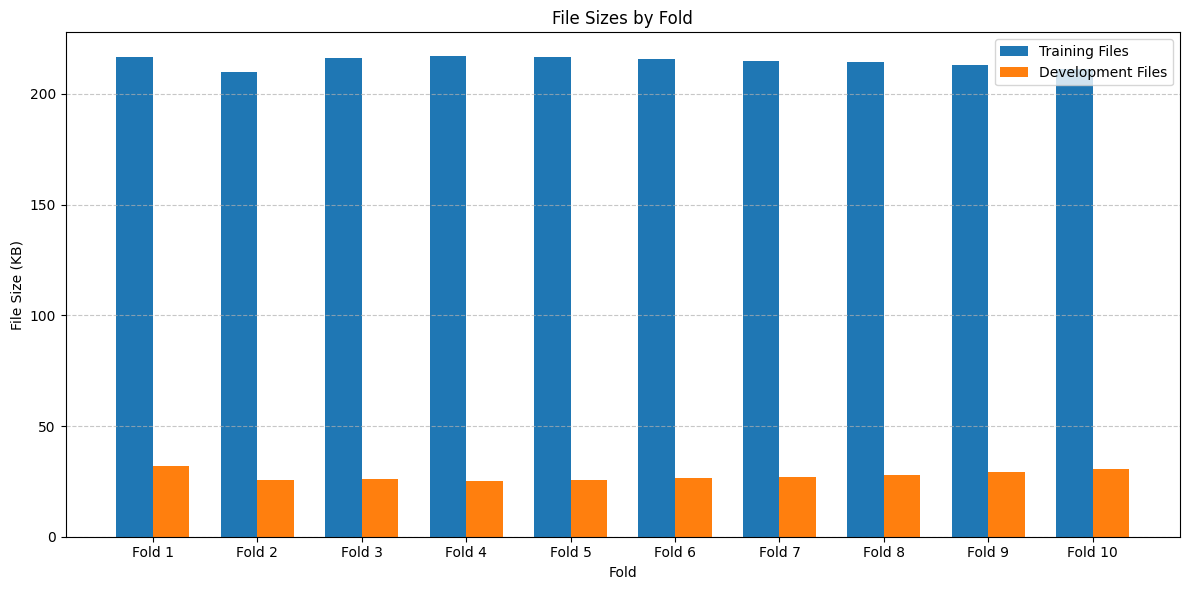

Data validation complete! Ready for training.


In [9]:
# Validate the directory paths
try:
    train_folder = validate_path(TRAIN_FOLDER)
    dev_folder = validate_path(DEV_FOLDER)
    output_dir = validate_path(OUTPUT_BASE_DIR, create_if_missing=True)
    
    print(f"✅ Train folder: {train_folder}")
    print(f"✅ Dev folder: {dev_folder}")
    print(f"✅ Output folder: {output_dir}")
except ValueError as e:
    print(f"❌ Path validation error: {e}")
    raise

# Get all train and dev files
try:
    train_files = validate_files(train_folder)
    dev_files = validate_files(dev_folder)
    
    print(f"\nFound {len(train_files)} training files and {len(dev_files)} development files.")
    
    # Ensure the number of train and dev files match
    if len(train_files) != len(dev_files):
        print(f"⚠️ Warning: Mismatch between train ({len(train_files)}) and dev ({len(dev_files)}) files count.")
        print("Training will continue with matched pairs only.")
    
    # Display file information in a DataFrame
    files_info = []
    
    for i, (train_file, dev_file) in enumerate(zip(train_files, dev_files), start=1):
        train_size = train_file.stat().st_size / 1024  # size in KB
        dev_size = dev_file.stat().st_size / 1024      # size in KB
        
        files_info.append({
            "Fold": i,
            "Train File": train_file.name,
            "Train Size (KB)": f"{train_size:.2f}",
            "Dev File": dev_file.name,
            "Dev Size (KB)": f"{dev_size:.2f}"
        })
    
    # Display as DataFrame
    files_df = pd.DataFrame(files_info)
    display(files_df)
    
    # Plot file sizes
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(files_info))
    width = 0.35
    
    train_sizes = [float(info["Train Size (KB)"]) for info in files_info]
    dev_sizes = [float(info["Dev Size (KB)"]) for info in files_info]
    
    plt.bar(x - width/2, train_sizes, width, label='Training Files')
    plt.bar(x + width/2, dev_sizes, width, label='Development Files')
    
    plt.xlabel('Fold')
    plt.ylabel('File Size (KB)')
    plt.title('File Sizes by Fold')
    plt.xticks(x, [f'Fold {i+1}' for i in range(len(files_info))])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print("Data validation complete! Ready for training.")
    
except ValueError as e:
    print(f"❌ File validation error: {e}")
    raise

## 4. Training Implementation

Let's implement the enhanced training function with progress tracking and metric collection.

In [12]:
class TrainingMonitor:
    """Monitor training progress and collect metrics from spaCy's output."""
    
    def __init__(self):
        self.metrics = []
        self.output_lines = []
        self.current_epoch = 0
        self.completed = False
        self.error = None
    
    def process_line(self, line):
        """Process a line of output from the training process."""
        self.output_lines.append(line)
        
        # Extract epoch information
        if "Epoch" in line and "score:" in line:
            try:
                # Parse metrics
                epoch = int(re.search(r"Epoch (\d+):", line).group(1))
                self.current_epoch = epoch
                
                # Only add metrics if we have all the scores
                if all(marker in line for marker in ["score:", "las:", "uas:"]):
                    score = float(re.search(r"score:\s+(\d+\.\d+)", line).group(1))
                    las = float(re.search(r"las:\s+(\d+\.\d+)", line).group(1))
                    uas = float(re.search(r"uas:\s+(\d+\.\d+)", line).group(1))
                    
                    self.metrics.append({
                        "epoch": epoch,
                        "score": score,
                        "las": las,
                        "uas": uas
                    })
            except Exception as e:
                # Skip lines that don't match the expected format
                pass
        
        # Check for training completion
        if "Saving model" in line:
            self.completed = True
        
        # Check for errors
        if "Error" in line or "ERROR" in line or "Exception" in line:
            self.error = line
    
    def get_metrics_df(self):
        """Get the metrics as a pandas DataFrame."""
        if not self.metrics:
            return pd.DataFrame()
        return pd.DataFrame(self.metrics)
    
    def get_last_metrics(self):
        """Get the metrics from the last epoch."""
        if not self.metrics:
            return None
        return self.metrics[-1]
    
    def get_full_output(self):
        """Get the full output as a string."""
        return "\n".join(self.output_lines)

# Enhanced train_fold function with progress tracking
def train_fold(fold_number, train_path, dev_path, output_dir, config=None):
    """Train a spaCy model for a fold with improved progress tracking.
    
    Args:
        fold_number: The fold number
        train_path: Path to the training file
        dev_path: Path to the development file
        output_dir: Path to the output directory
        config: Configuration dictionary (optional)
        
    Returns:
        tuple: (success, monitor) where monitor contains training metrics
    """
    # Use default config if none provided
    if config is None:
        config = TRAINING_CONFIG
        
    try:
        # Create the config string for the current fold
        # Normalize paths by replacing backslashes with forward slashes
        normalized_train_path = str(train_path).replace("\\", "/")
        normalized_dev_path = str(dev_path).replace("\\", "/")
        
        # Update parameters with paths
        params = config.copy()
        params.update({
            "train_path": normalized_train_path,
            "dev_path": normalized_dev_path
        })
        
        # Create the config string with all parameters
        config_string = config_template.format(**params)
        
        # Write the config file
        config_filename = f"config_fold{fold_number}.cfg"
        with open(config_filename, "w", encoding="utf-8") as f:
            f.write(config_string)
        
        print(f"Created configuration file: {config_filename}")
        
        # Define the output directory for the current fold
        os.makedirs(output_dir, exist_ok=True)
        
        # Build the command
        command = ["spacy", "train", config_filename, "--output", output_dir]
        
        # Add GPU option if enabled
        if config.get("use_gpu", False):
            command.append("--gpu-id")
            command.append("0")
        
        print(f"Running training command: {' '.join(command)}")
        
        # Initialize monitor
        monitor = TrainingMonitor()
        
        # Start the process
        process = subprocess.Popen(
            command,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True
        )
        
        # Use tqdm to show progress
        with tqdm(total=config.get("max_epochs", 10), desc=f"Training Fold {fold_number}") as pbar:
            last_epoch = 0
            
            # Process the output
            while True:
                # Read output line by line
                line = process.stdout.readline()
                if not line and process.poll() is not None:
                    break
                    
                if line:
                    line = line.strip()
                    monitor.process_line(line)
                    
                    # Update progress bar on epoch changes
                    if monitor.current_epoch > last_epoch:
                        pbar.update(monitor.current_epoch - last_epoch)
                        last_epoch = monitor.current_epoch
                        
                        # Display metrics for the current epoch
                        last_metrics = monitor.get_last_metrics()
                        if last_metrics:
                            pbar.set_postfix({"score": f"{last_metrics['score']:.2f}", 
                                              "las": f"{last_metrics['las']:.2f}", 
                                              "uas": f"{last_metrics['uas']:.2f}"})
                            
                    # Early stop if we completed training
                    if monitor.completed:
                        pbar.update(config.get("max_epochs", 10) - last_epoch)  # Complete the progress bar
                        break
                        
                    # Break if there was an error
                    if monitor.error:
                        print(f"❌ Error detected: {monitor.error}")
                        break
                        
        # Wait for process to complete and get return code
        return_code = process.wait()
        
        # Check if training was successful
        if return_code != 0:
            print(f"❌ Training failed for fold {fold_number} with return code {return_code}")
            return False, monitor
        
        print(f"✅ Training completed successfully for fold {fold_number}")
        return True, monitor
        
    except Exception as e:
        print(f"❌ Error in training fold {fold_number}: {e}")
        return False, None
    finally:
        # Clean up the config file
        if os.path.exists(config_filename):
            try:
                os.remove(config_filename)
            except Exception as e:
                print(f"Warning: Could not remove config file {config_filename}: {e}")

# Function to plot training metrics
def plot_training_metrics(monitor):
    """Plot the training metrics from a TrainingMonitor instance."""
    if not monitor or not monitor.metrics:
        print("No metrics available to plot.")
        return
    
    metrics_df = monitor.get_metrics_df()
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(metrics_df['epoch'], metrics_df['score'], 'b-', label='Score')
    plt.plot(metrics_df['epoch'], metrics_df['las'], 'r-', label='LAS')
    plt.plot(metrics_df['epoch'], metrics_df['uas'], 'g-', label='UAS')
    
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Training Metrics by Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Display metrics as table
    display(metrics_df)

## 5. Training Execution

Now let's execute the training on all folds and collect the metrics.

In [13]:
# Set to True to start training
RUN_TRAINING = True  # Set to True when ready to train

# Results collection
all_results = {}

if RUN_TRAINING:
    # Use the training_config from the configuration cell
    config = TRAINING_CONFIG
    
    # Track start time for total training duration
    start_time = time.time()
    
    # Validate train and dev files again to ensure they're still available
    train_files = validate_files(train_folder)
    dev_files = validate_files(dev_folder)
    
    # Create a progress bar for all folds
    folds_total = min(len(train_files), len(dev_files))
    
    print(f"Starting training for {folds_total} folds...")
    print(f"Using configuration: {config}")
    
    # Process each fold
    for fold_number, (train_file, dev_file) in enumerate(zip(train_files, dev_files), start=1):
        fold_start_time = time.time()
        
        print(f"\n{'='*80}")
        print(f"Processing Fold {fold_number}/{folds_total}:")
        print(f"  Train File: {train_file.name}")
        print(f"  Dev File: {dev_file.name}")
        
        # Define the output directory for the current fold
        output_dir = os.path.join(OUTPUT_BASE_DIR, f"fold{fold_number}")
        print(f"  Output Directory: {output_dir}")
        
        # Train the fold
        success, monitor = train_fold(
            fold_number=fold_number, 
            train_path=train_file, 
            dev_path=dev_file, 
            output_dir=output_dir,
            config=config
        )
        
        # Record results
        fold_time = time.time() - fold_start_time
        fold_metrics = None
        
        if success and monitor:
            fold_metrics = monitor.get_last_metrics()
            all_results[f"fold{fold_number}"] = {
                "train_file": train_file.name,
                "dev_file": dev_file.name,
                "success": success,
                "metrics": fold_metrics,
                "time": fold_time,
                "all_metrics": monitor.metrics
            }
            
            # Plot the training metrics
            print(f"\nTraining metrics for Fold {fold_number}:")
            plot_training_metrics(monitor)
        else:
            all_results[f"fold{fold_number}"] = {
                "train_file": train_file.name,
                "dev_file": dev_file.name,
                "success": False,
                "time": fold_time
            }
        
        print(f"Fold {fold_number} completed in {fold_time:.2f} seconds.")
        if fold_metrics:
            print(f"Final metrics - Score: {fold_metrics['score']:.2f}, LAS: {fold_metrics['las']:.2f}, UAS: {fold_metrics['uas']:.2f}")
    
    # Save the results to a JSON file for later analysis
    results_file = "training_results.json"
    
    # Convert metrics to serializable format
    serializable_results = {}
    for fold, data in all_results.items():
        serializable_fold = {}
        for key, value in data.items():
            if key == 'all_metrics':
                # Convert list of dicts to serializable format
                serializable_fold[key] = value
            elif key == 'metrics':
                # Convert single dict to serializable format
                if value is not None:
                    serializable_fold[key] = value
                else:
                    serializable_fold[key] = None
            else:
                serializable_fold[key] = value
        serializable_results[fold] = serializable_fold
    
    with open(results_file, "w", encoding="utf-8") as f:
        json.dump(serializable_results, f, indent=2)
    
    total_time = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"All folds completed in {total_time:.2f} seconds.")
    print(f"Results saved to {results_file}")
else:
    print("Training is not enabled. Set RUN_TRAINING = True to start the training process.")

Starting training for 10 folds...
Using configuration: {'language': 'th', 'pipeline': ['parser'], 'batch_size': 1000, 'max_epochs': 10, 'dropout': 0.2, 'patience': 3, 'eval_frequency': 1000, 'seed': 42, 'gpu_allocator': 'cpu', 'learn_rate': 0.001, 'use_gpu': False, 'show_progress': True}

Processing Fold 1/10:
  Train File: train_1(2_10).spacy
  Dev File: 1doc1sent_fold_10_fixed.spacy
  Output Directory: ./output\fold1
Created configuration file: config_fold1.cfg
Running training command: spacy train config_fold1.cfg --output ./output\fold1


Training Fold 1:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 1 with return code 1
Fold 1 completed in 2.20 seconds.

Processing Fold 2/10:
  Train File: train_10(1_9).spacy
  Dev File: 1doc1sent_fold_1_fixed.spacy
  Output Directory: ./output\fold2
Created configuration file: config_fold2.cfg
Running training command: spacy train config_fold2.cfg --output ./output\fold2


Training Fold 2:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 2 with return code 1
Fold 2 completed in 1.99 seconds.

Processing Fold 3/10:
  Train File: train_2(3_10+1).spacy
  Dev File: 1doc1sent_fold_2_fixed.spacy
  Output Directory: ./output\fold3
Created configuration file: config_fold3.cfg
Running training command: spacy train config_fold3.cfg --output ./output\fold3


Training Fold 3:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 3 with return code 1
Fold 3 completed in 2.03 seconds.

Processing Fold 4/10:
  Train File: train_3(4_10+1 2).spacy
  Dev File: 1doc1sent_fold_3_fixed.spacy
  Output Directory: ./output\fold4
Created configuration file: config_fold4.cfg
Running training command: spacy train config_fold4.cfg --output ./output\fold4


Training Fold 4:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 4 with return code 1
Fold 4 completed in 2.06 seconds.

Processing Fold 5/10:
  Train File: train_4(5_10+1 2 3).spacy
  Dev File: 1doc1sent_fold_4_fixed.spacy
  Output Directory: ./output\fold5
Created configuration file: config_fold5.cfg
Running training command: spacy train config_fold5.cfg --output ./output\fold5


Training Fold 5:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 5 with return code 1
Fold 5 completed in 2.10 seconds.

Processing Fold 6/10:
  Train File: train_5(6_10+1 2 3 4).spacy
  Dev File: 1doc1sent_fold_5_fixed.spacy
  Output Directory: ./output\fold6
Created configuration file: config_fold6.cfg
Running training command: spacy train config_fold6.cfg --output ./output\fold6


Training Fold 6:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 6 with return code 1
Fold 6 completed in 2.06 seconds.

Processing Fold 7/10:
  Train File: train_6(7_10+1 2 3 4 5).spacy
  Dev File: 1doc1sent_fold_6_fixed.spacy
  Output Directory: ./output\fold7
Created configuration file: config_fold7.cfg
Running training command: spacy train config_fold7.cfg --output ./output\fold7


Training Fold 7:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 7 with return code 1
Fold 7 completed in 1.96 seconds.

Processing Fold 8/10:
  Train File: train_7(8_10+1_6).spacy
  Dev File: 1doc1sent_fold_7_fixed.spacy
  Output Directory: ./output\fold8
Created configuration file: config_fold8.cfg
Running training command: spacy train config_fold8.cfg --output ./output\fold8


Training Fold 8:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 8 with return code 1
Fold 8 completed in 1.96 seconds.

Processing Fold 9/10:
  Train File: train_8(9_10+1_7).spacy
  Dev File: 1doc1sent_fold_8_fixed.spacy
  Output Directory: ./output\fold9
Created configuration file: config_fold9.cfg
Running training command: spacy train config_fold9.cfg --output ./output\fold9


Training Fold 9:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 9 with return code 1
Fold 9 completed in 1.97 seconds.

Processing Fold 10/10:
  Train File: train_9(1_8+10)).spacy
  Dev File: 1doc1sent_fold_9_fixed.spacy
  Output Directory: ./output\fold10
Created configuration file: config_fold10.cfg
Running training command: spacy train config_fold10.cfg --output ./output\fold10


Training Fold 10:   0%|          | 0/10 [00:00<?, ?it/s]

❌ Training failed for fold 10 with return code 1
Fold 10 completed in 2.02 seconds.

All folds completed in 20.37 seconds.
Results saved to training_results.json


## 6. Results Visualization and Analysis

Let's visualize the results of the training across all folds.

In [ ]:
# Load results from file if they exist, otherwise use the results from training
results_file = "training_results.json"

if os.path.exists(results_file):
    try:
        with open(results_file, "r", encoding="utf-8") as f:
            loaded_results = json.load(f)
        
        if not RUN_TRAINING:  # Only load from file if we didn't just run training
            all_results = loaded_results
            print(f"Loaded training results from {results_file}")
    except Exception as e:
        print(f"Error loading results file: {e}")

# Check if we have results to visualize
if all_results:
    # Prepare summary data
    summary_data = []
    
    for fold, data in all_results.items():
        fold_summary = {
            "Fold": fold,
            "Train File": data.get("train_file", ""),
            "Dev File": data.get("dev_file", ""),
            "Success": "✅" if data.get("success", False) else "❌",
            "Time (s)": f"{data.get('time', 0):.2f}"
        }
        
        metrics = data.get("metrics")
        if metrics:
            fold_summary["Score"] = f"{metrics.get('score', 0):.2f}"
            fold_summary["LAS"] = f"{metrics.get('las', 0):.2f}"
            fold_summary["UAS"] = f"{metrics.get('uas', 0):.2f}"
        else:
            fold_summary["Score"] = "N/A"
            fold_summary["LAS"] = "N/A"
            fold_summary["UAS"] = "N/A"
        
        summary_data.append(fold_summary)
    
    # Display summary table
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Plot metrics comparison across folds
    successful_folds = []
    scores = []
    las_values = []
    uas_values = []
    
    for fold, data in all_results.items():
        if data.get("success", False) and data.get("metrics"):
            successful_folds.append(fold)
            metrics = data["metrics"]
            scores.append(metrics.get("score", 0))
            las_values.append(metrics.get("las", 0))
            uas_values.append(metrics.get("uas", 0))
    
    if successful_folds:
        plt.figure(figsize=(12, 6))
        
        x = range(len(successful_folds))
        width = 0.25
        
        plt.bar([i - width for i in x], scores, width, label='Score')
        plt.bar([i for i in x], las_values, width, label='LAS')
        plt.bar([i + width for i in x], uas_values, width, label='UAS')
        
        plt.xlabel('Fold')
        plt.ylabel('Metric Value')
        plt.title('Performance Metrics by Fold')
        plt.xticks(x, successful_folds)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        stats = {
            "Score": {
                "Mean": np.mean(scores),
                "Std": np.std(scores),
                "Min": np.min(scores),
                "Max": np.max(scores)
            },
            "LAS": {
                "Mean": np.mean(las_values),
                "Std": np.std(las_values),
                "Min": np.min(las_values),
                "Max": np.max(las_values)
            },
            "UAS": {
                "Mean": np.mean(uas_values),
                "Std": np.std(uas_values),
                "Min": np.min(uas_values),
                "Max": np.max(uas_values)
            }
        }
        
        # Create statistics DataFrame
        stats_df = pd.DataFrame({
            "Metric": ["Score", "LAS", "UAS"],
            "Mean": [stats["Score"]["Mean"], stats["LAS"]["Mean"], stats["UAS"]["Mean"]],
            "Std Dev": [stats["Score"]["Std"], stats["LAS"]["Std"], stats["UAS"]["Std"]],
            "Min": [stats["Score"]["Min"], stats["LAS"]["Min"], stats["UAS"]["Min"]],
            "Max": [stats["Score"]["Max"], stats["LAS"]["Max"], stats["UAS"]["Max"]]
        })
        
        # Display cross-fold statistics
        print("\nCross-Fold Performance Statistics:")
        display(stats_df)
        
        # Analyze training times
        training_times = [data.get('time', 0) for fold, data in all_results.items() 
                        if data.get("success", False)]
        
        if training_times:
            plt.figure(figsize=(10, 4))
            plt.bar(successful_folds, training_times)
            plt.xlabel('Fold')
            plt.ylabel('Training Time (seconds)')
            plt.title('Training Time by Fold')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
            print(f"Average training time: {np.mean(training_times):.2f} seconds")
    else:
        print("No successful training folds to visualize.")
else:
    print("No training results available. Run the training cell with RUN_TRAINING = True first.")

## 7. Using the Best Model

After training, you can load and use the best model for inference. This example shows how to load the model from a specific fold.

In [ ]:
def load_model(fold_number):
    """Load a trained model from a specific fold."""
    model_path = os.path.join(OUTPUT_BASE_DIR, f"fold{fold_number}", "model-best")
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found at {model_path}")
        return None
    
    try:
        print(f"Loading model from {model_path}...")
        nlp = spacy.load(model_path)
        print(f"✅ Model loaded successfully")
        return nlp
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Example: Uncomment to load a model
# nlp = load_model(fold_number=1)
# 
# if nlp:
#     # Example text for parsing
#     text = "Your example text here"
#     doc = nlp(text)
#     
#     # Display parsed results
#     for token in doc:
#         print(f"{token.text}\t{token.dep_}\t{token.head.text}")

## How to Use This Notebook

This notebook provides a complete workflow for training spaCy models with cross-validation. Here's how to use it:

### 1. Setup and Configuration
- Ensure your training and development files are in the correct directories (`./content/train/` and `./content/dev/`)
- Modify the `TRAINING_CONFIG` dictionary in cell 2 to adjust training parameters
- Specify GPU usage by setting `"use_gpu": True/False` in the configuration

### 2. Data Validation
- Run the data validation cell to verify your input files are correctly recognized
- Check the file size visualization to ensure your training and development sets are balanced

### 3. Training
- Set `RUN_TRAINING = True` in cell 5 to start the training process
- Training progress will be displayed with a progress bar for each fold
- Metrics will be collected and visualized after each fold completes

### 4. Results Analysis
- After training completes, the results visualization cell will display performance across all folds
- Cross-fold statistics help identify the overall model performance and consistency
- All results are saved to `training_results.json` for later reference

### 5. Using the Models
- Use the `load_model()` function to load a trained model from a specific fold
- The best models for each fold are saved in `./output/fold{N}/model-best/`

### Tips
- For better performance, use GPU if available by setting `"use_gpu": True`
- Experiment with different training parameters to find the optimal configuration
- You can save custom configurations with `save_config()` and load them with `load_config()`
- If you run into memory issues, try reducing the batch size in the configuration